# Tensor Flow Introduction
November 2016, KN

In [3]:
# Import modules
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

In [ ]:
# Import more modules
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt

## Intro
Going through simple tutorial first, just to go through https://www.tensorflow.org/versions/r0.11/tutorials/mnist/beginners/index.html

In [4]:
# Load up MNIST data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


Dimensions of training set: (55000, 784)


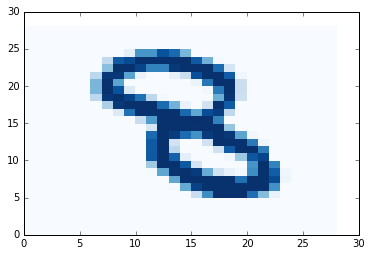

In [27]:
# Illustrate raw data
print('Dimensions of training set: {0}'.format(np.shape(mnist.train.images)))
exInd = 5
exImage = mnist.train.images[exInd,:].reshape(28,-1)  # 28x28 pixels in each image
plt.pcolormesh(exImage, cmap='Blues')

In [48]:
# Set-up tensor flow variables
dimen = 28*28  # Size of images and therefore the imput vectors
numClasses = 10   # Number of possible digits (0-9)

# Placeholders
x = tf.placeholder(tf.float32, shape=[None, dimen])
# None means dimension can be of any length
# Doing this to create placeholder for each 28x28 pixel image
y_true = tf.placeholder(tf.float32, shape=[None, numClasses])
# one-hot vector indivating true digit class

# Variables
# (model parameters are usually tensorflow variables)
# Need to initialize values for variables
w = tf.Variable(tf.zeros([dimen,numClasses]))
b = tf.Variable(tf.zeros([numClasses]))

# Softmax
y = tf.nn.softmax(tf.matmul(x,w) + b)

# Cross-entropy
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_true*tf.log(y), reduction_indices=[1]))
# tf.reduce_mean gets mean cross-entropy for all samples
# more numerically stable:
#cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y, y_true))
# but then softmax already taken, so would remove from y function 

# Need to initialize variables and launch a session
# Session is connection to C++ code backend to do computation
# First, create graph and then launch in a session
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)

In [49]:
# Optimize
learnRate = 0.5
train_step = tf.train.GradientDescentOptimizer(learnRate).minimize(cross_entropy)
# When this step is run, it will apply gradient descent updates to params

# Running training step
numSteps = 1000
batchSize = 100
for i in range(numSteps):
    batch_xs, batch_ys = mnist.train.next_batch(batchSize)
    sess.run(train_step, feed_dict={x: batch_xs, y_true: batch_ys})
    # feed_dict replaces placeholders with training examples
    # (can use feed_dict to replace any tensor in computation graph)

In [50]:
# Look at performance in training data
predLabels = tf.argmax(y,1)
trueLabels = tf.argmax(y_true,1)

ifCorrect = tf.equal(predLabels, trueLabels)

accFunc = tf.reduce_mean(tf.cast(ifCorrect, tf.float32))

In [51]:
# Look at performance in test data

testPerf_acc = sess.run(accFunc, feed_dict={x:mnist.test.images, y_true:mnist.test.labels})
print('Test accuracy: {0:.2f}%'.format(100*testPerf_acc))

Test accuracy: 91.81%


## With interactive session

https://www.tensorflow.org/versions/r0.11/tutorials/mnist/pros/index.html

In [53]:
# Or, can use an interactive session
# With interactive session, can interleave graph-building and graph-running operations
sess2 = tf.InteractiveSession()

# (As above)
dimen = 28*28  # Size of images and therefore the imput vectors
numClasses = 10   # Number of possible digits (0-9)
# Placeholders
x = tf.placeholder(tf.float32, shape=[None, dimen])
y_ = tf.placeholder(tf.float32, shape=[None, numClasses])
# Variables
w = tf.Variable(tf.zeros([dimen,numClasses]))
b = tf.Variable(tf.zeros([numClasses]))
# Regression model
y = tf.matmul(x,w) + b
# Cross-entropy
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y, y_))

sess2.run(tf.initialize_all_variables())

# Optimize
learnRate = 0.5
train_step = tf.train.GradientDescentOptimizer(learnRate).minimize(cross_entropy)

# Running training step
numSteps = 1000
batchSize = 100
for i in range(numSteps):
    batch = mnist.train.next_batch(batchSize)
    train_step.run(feed_dict={x: batch[0], y_: batch[1]})
    
# Look at performance
predLabels = tf.argmax(y,1)
trueLabels = tf.argmax(y_,1)

ifCorrect = tf.equal(predLabels, trueLabels)
accFunc = tf.reduce_mean(tf.cast(ifCorrect, tf.float32))

testPerf_acc = accFunc.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels})
print('Test accuracy: {0:.2f}%'.format(100*testPerf_acc))


Test accuracy: 91.95%


## Simply conv net

https://www.tensorflow.org/versions/r0.11/tutorials/mnist/pros/index.html

Remember: CNN is a bunch of convolution layers + ReLU applied
(where the filters [= conv layers = kernels = filters = feature detectors] are learned)

In [ ]:
# Make some functions 

def weight_variable(shape):
    """Want weight initializations to have noise for symmetry breaking"""
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    """Want positive bias for ReLU neurons to avoid dead neurons (i.e., never activate)"""
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x,W):
    """Want to set stride and keep zero padding
    
    Zero padding: means that when applying convolution at edges, pad with zeros 
    to enable the computation (vs. narrow convolution)
    
    Stride size: amount to shift filter in each step
    """
    return tf.nn.conv2d(x,W, strides=[1,1,1,1], padding='SAME')

def max_pool_2x2(x):
    """Want to do max pooling over 2x2 blocks"""
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

In [ ]:
# Set variables
patchSize = [5,5]
numInputChannels = 1  # (number color channels)
numOutputChannels = 32
dim1side = 28

# Create first convolutional layer
W_conv1 = weight_variable([patchSize[0], patchSize[1], numInputChannels, numOutputChannels])
b_conv1 = bias_variable([numOutputChannels])

# reshape images into 4d tensor of: [numExamples, width, height, num color channels]
x_image = tf.reshape(x, [-1, dim1side, dim1side,numInputChannels])

# convolve image with weight tensor and add bias
conv1 = conv2d(x_image, W_conv1) + b_conv1
# apply ReLU function
h_conv1 = tf.nn.relu(conv1)
# max pool
h_pool1 = max_pool_2x2(h_conv1)

In [54]:
np.shape(x)

()

In [58]:
A = [[3,2], [1,4]]
B = [[4,3],[2,2]]

np.dot(A,B)

array([[16, 13],
       [12, 11]])